In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

## Verinin Yüklenmesi

In [2]:
train_data = pd.read_csv("/content/cure_the_princess_train.csv")
val_data = pd.read_csv("/content/cure_the_princess_validation.csv")
test_data = pd.read_csv("/content/cure_the_princess_test.csv")

In [3]:
train_data["Cured"].value_counts()

0    635
1    617
Name: Cured, dtype: int64

## Verilerin Bölünmesi (inputs-labels şeklinde)

In [4]:
input_train = train_data[train_data.columns[:-1]]
labels_train = train_data[train_data.columns[-1]]

input_val = val_data[val_data.columns[:-1]]
labels_val = val_data[val_data.columns[-1]]

input_test = test_data[test_data.columns[:-1]]
labels_test = test_data[test_data.columns[-1]]

In [5]:
input_train = torch.tensor(input_train.values, dtype=torch.float32)
labels_train = torch.tensor(labels_train.values, dtype=torch.float32)
input_val = torch.tensor(input_val.values, dtype=torch.float32)
labels_val = torch.tensor(labels_val.values, dtype=torch.float32)
input_test = torch.tensor(input_test.values, dtype=torch.float32)
labels_test = torch.tensor(labels_test.values, dtype=torch.float32)

## Verilerin DataLoader Formatına Getirilmesi

In [6]:
torch.manual_seed(160401003)

In [7]:
from torch.utils.data import TensorDataset, DataLoader

In [8]:
train_dataset = DataLoader(TensorDataset(input_train, labels_train), batch_size=16, shuffle=True)

val_dataset = DataLoader(TensorDataset(input_val, labels_val), batch_size=16, shuffle=True)

test_dataset = DataLoader(TensorDataset(input_test, labels_test), batch_size=16, shuffle=True)

## Yapay Sinir Ağının Oluşturulması

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, num_input, num_neurons1, num_neurons2):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = nn.Linear(num_input, num_neurons1) 
        self.hidden_layer_2 = nn.Linear(num_neurons1, num_neurons2)
        self.output_layer = nn.Linear(num_neurons2, 1) 

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))

        x = self.relu(self.hidden_layer_2(x))

        x = self.sigmoid(self.output_layer(x))

        return x

## Modelin Eğitilmesi

In [10]:
import matplotlib.pyplot as plt

Epoch 1 train loss: 0.6682558414302294, validation loss: 0.5871512547135354
Epoch 2 train loss: 0.5652281045913696, validation loss: 0.49377896189689635
Epoch 3 train loss: 0.5024634162081948, validation loss: 0.4414946809411049
Epoch 4 train loss: 0.4639140590082241, validation loss: 0.4515573889017105
Patience Counter: 1
Epoch 5 train loss: 0.4382129707668401, validation loss: 0.36871783509850503
Epoch 6 train loss: 0.4149975880414625, validation loss: 0.3436203241348267
Epoch 7 train loss: 0.3949772240240363, validation loss: 0.3600554257631302
Patience Counter: 1
Epoch 8 train loss: 0.3762491639656357, validation loss: 0.31398119404911995
Epoch 9 train loss: 0.36920066630538506, validation loss: 0.30795930698513985
Epoch 10 train loss: 0.34775205861918534, validation loss: 0.2898523278534412
Epoch 11 train loss: 0.341447361662418, validation loss: 0.2935836143791676
Patience Counter: 1
Epoch 12 train loss: 0.33300887312315686, validation loss: 0.2722868904471397
Epoch 13 train loss

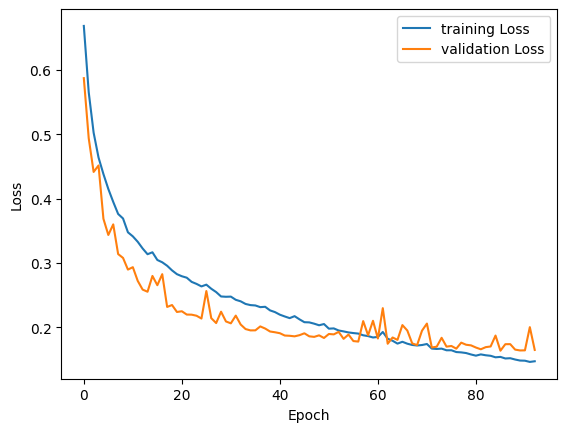

Eğitim bitti.


In [11]:
model = NeuralNet(13,100,50)
lr=0.001
num_epochs=120

loss_func = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

loss_train = []
loss_val = []

best_val_score = None
patience_number=7
for epoch in range(num_epochs):

  train_loss = 0.0
  val_loss = 0.0
  
  for inputs, labels in train_dataset:
      optimizer.zero_grad()

      outputs = model(inputs)
      labels = labels.unsqueeze(1)
      loss = loss_func(outputs, labels)
      loss.backward()
      optimizer.step()

      
      train_loss += loss.item()
    

  model.eval()
  with torch.no_grad():
    for inputs, targets in val_dataset:
      outputs = model(inputs)
      targets = targets.reshape(-1,1)
      loss = loss_func(outputs, targets)

      val_loss += loss.item()

  model.train()

  train_loss /= len(train_dataset)
  val_loss /= len(val_dataset)

  print(f"Epoch {epoch+1} train loss: {train_loss}, validation loss: {val_loss}")

  loss_train.append(train_loss)
  loss_val.append(val_loss)

  val_score = val_loss
  if best_val_score is None:
    best_val_score = val_score
    torch.save(model.state_dict(), "best_model.pt")
  elif best_val_score < val_score: 
    patience_counter += 1
    print("Patience Counter:",patience_counter)
    if patience_counter == patience_number:
      print("Stopping...")
      torch.save(model.state_dict(), "best_model.pt")
      break
  else:
    best_val_score = val_score
    torch.save(model.state_dict(), "best_model.pt")
    patience_counter = 0
  


plt.plot(loss_train, label='training Loss')
plt.plot(loss_val, label='validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
        

print('Eğitim bitti.')

In [12]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [14]:
best_model = NeuralNet(13,100,50)
checkpoint = torch.load('/content/best_model.pt')
best_model.load_state_dict(checkpoint)
best_model.eval()

preds = []
real_labels = []

with torch.no_grad():
  for inputs,label in test_dataset:

      output = best_model(inputs)

      for i in output:
        predict = 0 if i<0.5 else 1
        preds.append(predict)
     
      
      for i in label:
        real_labels.append(int(i))

accuracy = accuracy_score(real_labels,preds)      
f1_score = f1_score(real_labels,preds)
precision = precision_score(real_labels,preds)
recall = recall_score(real_labels,preds)

print(f"Accuracy: " + str(accuracy) +", F1-Score: " + str(f1_score) + 
      ", Precision: " + str(precision) + ", Recall: " + str(recall))

Accuracy: 0.9352331606217616, F1-Score: 0.9331550802139037, Precision: 0.9694444444444444, Recall: 0.8994845360824743
